# Model Training with Undersampling - Colton Hester

This notebook implements the following modeling approach:
- **Missing Values**: Zero and subgroup means imputation (handled by pipeline)
- **Imbalance Handling**: Undersampling (applied to training data only)
- **Baseline**: Random Forest
- **Improvement 1**: Feed Forward Neural Network (FFNN)
- **Improvement 2**: Entity Embeddings for categorical variables

**Metrics**: Accuracy, Precision, Recall, F1 (macro average)

## 1. Setup & Imports

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

from tensorflow import keras
from tensorflow.keras import layers, Model

# our preprocessing pipeline
from src.preprocessing_pipeline import build_preprocessed_data

# set random seed for reproducibility
RANDOM_STATE = 207
np.random.seed(RANDOM_STATE)

print("Imports complete.")

2025-12-13 20:44:46.783368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765687486.801922   79213 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765687486.808034   79213 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765687486.823810   79213 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765687486.823842   79213 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765687486.823844   79213 computation_placer.cc:177] computation placer alr

Imports complete.


## 2. Load Data with Undersampling

In [2]:
# load data with undersampling applied to training data
print("Loading and preprocessing data with undersampling...")
data = build_preprocessed_data(use_undersample=True)

# extract arrays
X_train = data['X_train_std']
y_train = data['Y_train']
X_val = data['X_val_std']
y_val = data['Y_val']
X_test = data['X_test_std']
y_test = data['Y_test']

print(f"\nTraining shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")

# check class distribution
print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples")

Loading and preprocessing data with undersampling...
Scanning CSV for column names...
Loading 48 columns (out of 308 total)...
File loaded successfully with Polars. Shape: (2302521, 48)
Converting to Pandas...
Conversion complete. Pandas shape: (2302521, 48)
Applying undersampling to training data...
Undersampling: class counts before = {0: 1345082, 1: 33560, 2: 2210, 3: 660}
Undersampling: target count per class = 660
Undersampling: final shape = (2640, 53)
Undersampling done.

Training shape: (2640, 52)
Validation shape: (460504, 52)
Test shape: (460505, 52)

Number of features: 52
Number of classes: 4

Training class distribution:
  Class 0: 660 samples
  Class 1: 660 samples
  Class 2: 660 samples
  Class 3: 660 samples


## 3. Helper Functions for Metrics

In [3]:
def get_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, &and F1 score using macro average."""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def print_metrics(metrics, name="Model"):
    """Print metrics in a formatted way."""
    print(f"\n{name} Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# store results for comparison
results = {}

---
## 4. Baseline: Random Forest

In [4]:
print("Training Random Forest baseline...")

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1  # use all CPU cores
)

rf.fit(X_train, y_train)
print("Training complete.")

Training Random Forest baseline...
Training complete.


In [5]:
# validation metrics
y_pred_val_rf = rf.predict(X_val)
rf_val_metrics = get_metrics(y_val, y_pred_val_rf)
print_metrics(rf_val_metrics, "Random Forest (Validation)")

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val_rf))


Random Forest (Validation) Metrics:
  Accuracy:  0.6453
  Precision: 0.2620
  Recall:    0.5203
  F1 Score:  0.2233

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.65      0.79    448361
           1       0.05      0.38      0.08     11185
           2       0.01      0.40      0.01       738
           3       0.01      0.65      0.01       220

    accuracy                           0.65    460504
   macro avg       0.26      0.52      0.22    460504
weighted avg       0.96      0.65      0.77    460504




Random Forest (Test) Metrics:
  Accuracy:  0.6454
  Precision: 0.2618
  Recall:    0.5085
  F1 Score:  0.2231


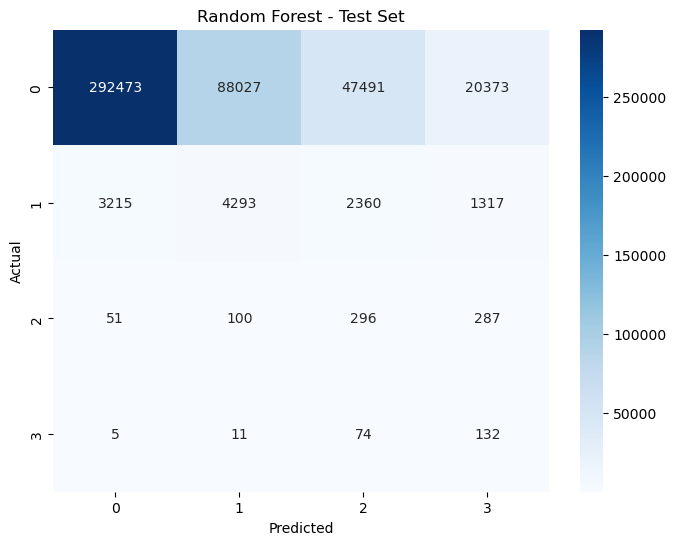

In [6]:
# test metrics
y_pred_test_rf = rf.predict(X_test)
rf_test_metrics = get_metrics(y_test, y_pred_test_rf)
print_metrics(rf_test_metrics, "Random Forest (Test)")

# store results
results['Random Forest'] = {
    'val': rf_val_metrics,
    'test': rf_test_metrics
}

plot_confusion_matrix(y_test, y_pred_test_rf, "Random Forest - Test Set")

---
## 5. Improvement 1: Feed Forward Neural Network (FFNN)

In [7]:
# ensure correct data types for TensorFlow
X_train_tf = X_train.astype('float32')
X_val_tf = X_val.astype('float32')
X_test_tf = X_test.astype('float32')
y_train_tf = y_train.astype('int32')
y_val_tf = y_val.astype('int32')
y_test_tf = y_test.astype('int32')

num_features = X_train_tf.shape[1]
num_classes = len(np.unique(y_train))

print(f"Features: {num_features}, Classes: {num_classes}")

Features: 52, Classes: 4


In [8]:
def build_ffnn(input_dim, num_classes):
    """Build a FFNN (Feed Forward Neural Network)."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

ffnn = build_ffnn(num_features, num_classes)
ffnn.summary()

I0000 00:00:1765687533.862800   79213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13715 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,604 (21.89 KB)

 Trainable params: 5,604 (21.89 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train FFNN
print("Training FFNN...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_ffnn = ffnn.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Training FFNN...
Epoch 1/50


I0000 00:00:1765687536.763968   79546 service.cc:152] XLA service 0x7d6f1400a350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765687536.764022   79546 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-12-13 20:45:36.855969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765687537.054929   79546 cuda_dnn.cc:529] Loaded cuDNN version 91002


 1/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1992 - loss: 1.6261

I0000 00:00:1765687539.193089   79546 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 845ms/step - accuracy: 0.2905 - loss: 1.4674 - val_accuracy: 0.7381 - val_loss: 1.0684
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.3799 - loss: 1.3186 - val_accuracy: 0.7012 - val_loss: 1.0292
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4019 - loss: 1.2772 - val_accuracy: 0.6674 - val_loss: 1.0485
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.4303 - loss: 1.2369 - val_accuracy: 0.6563 - val_loss: 1.0476
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.4295 - loss: 1.2092 - val_accuracy: 0.6613 - val_loss: 1.0256
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.4432 - loss: 1.1977 - val_accuracy: 0.6793 - val_loss: 0.9830
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - accuracy: 0.4572 - loss: 1.1826 - val_accuracy: 0.6786 - val_loss: 0.9720
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.4511 - loss: 1.1635 - val_accuracy: 0.6627 - val_

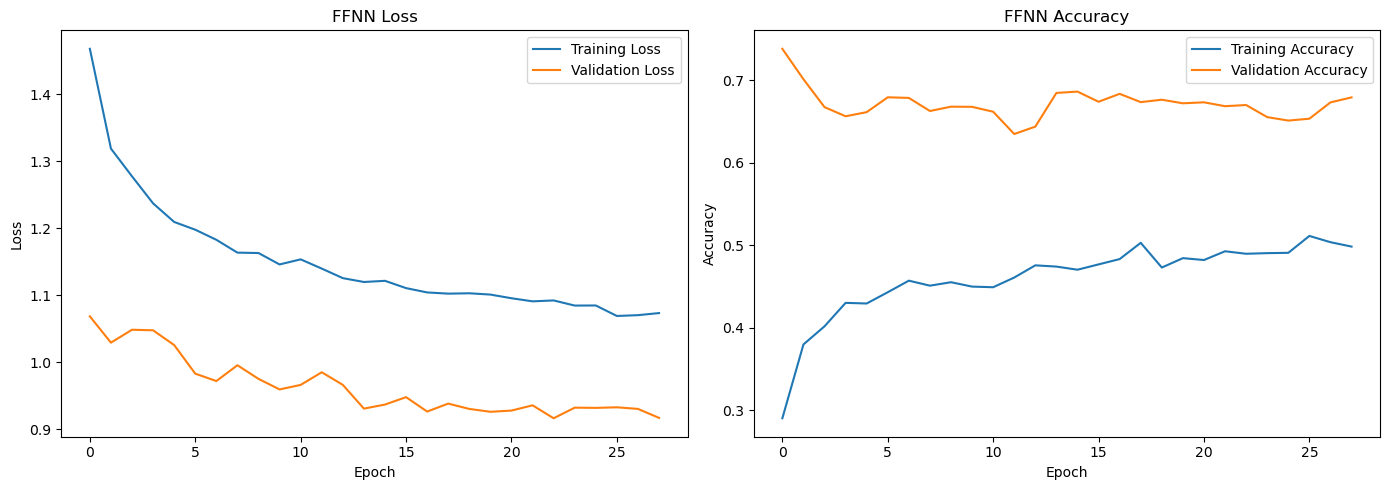

In [10]:
# plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_ffnn.history['loss'], label='Training Loss')
ax1.plot(history_ffnn.history['val_loss'], label='Validation Loss')
ax1.set_title('FFNN Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_ffnn.history['accuracy'], label='Training Accuracy')
ax2.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('FFNN Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
14391/14391 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step

FFNN (Validation) Metrics:
  Accuracy:  0.6699
  Precision: 0.2593
  Recall:    0.4925
  F1 Score:  0.2241

FFNN (Test) Metrics:
  Accuracy:  0.6693
  Precision: 0.2595
  Recall:    0.4979
  F1 Score:  0.2245


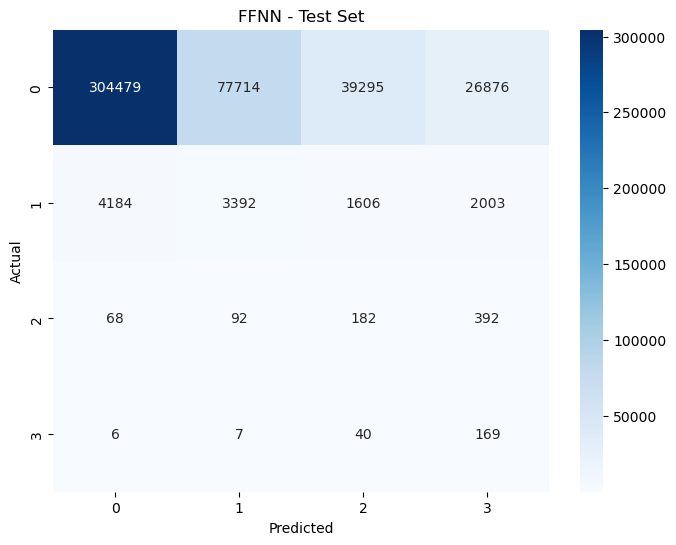

In [11]:
# FFNN metrics
y_pred_val_ffnn = np.argmax(ffnn.predict(X_val_tf), axis=1)
y_pred_test_ffnn = np.argmax(ffnn.predict(X_test_tf), axis=1)

ffnn_val_metrics = get_metrics(y_val, y_pred_val_ffnn)
ffnn_test_metrics = get_metrics(y_test, y_pred_test_ffnn)

print_metrics(ffnn_val_metrics, "FFNN (Validation)")
print_metrics(ffnn_test_metrics, "FFNN (Test)")

results['FFNN'] = {
    'val': ffnn_val_metrics,
    'test': ffnn_test_metrics
}

plot_confusion_matrix(y_test, y_pred_test_ffnn, "FFNN - Test Set")

---
## 6. Improvement 2: True Entity Embeddings

Entity embeddings learn dense vector representations for categorical variables, 
instead of one-hot encoding. This can capture relationships between categories 
and often improves performance for tabular data.

**Implementation**: We use the pipeline's `use_entity_embeddings=True` option to:
1. Keep categorical features as integer indices (not one-hot encoded)
2. Pass them through Keras `Embedding` layers
3. Concatenate learned embeddings with continuous features

**Categorical features for embedding**:
- `NWCG_CAUSE_CLASSIFICATION`: Fire cause (3 categories)
- `GACC_PL`: Geographic Area Coordination Center preparedness level (~6 categories)

In [12]:
# load data with entity embeddings support
print("Loading data with entity embeddings (integer-encoded categoricals)...")
data_embed = build_preprocessed_data(use_undersample=True, use_entity_embeddings=True)

# extract arrays - separate continuous and categorical
X_train_cont = data_embed['X_train_cont'].astype('float32')
X_val_cont = data_embed['X_val_cont'].astype('float32')
X_test_cont = data_embed['X_test_cont'].astype('float32')

X_train_cat = data_embed['X_train_cat']
X_val_cat = data_embed['X_val_cat']
X_test_cat = data_embed['X_test_cat']

y_train_embed = data_embed['Y_train']
y_val_embed = data_embed['Y_val']
y_test_embed = data_embed['Y_test']

print(f"\nContinuous features shape: {X_train_cont.shape}")
print(f"Categorical features shape: {X_train_cat.shape}")
print(f"Training samples: {len(y_train_embed)}")
print(f"\nCardinalities: {data_embed['cardinalities']}")
print(f"Categorical columns: {data_embed['cols_categorical']}")

Loading data with entity embeddings (integer-encoded categoricals)...
Scanning CSV for column names...
Loading 48 columns (out of 308 total)...
File loaded successfully with Polars. Shape: (2302521, 48)
Converting to Pandas...
Conversion complete. Pandas shape: (2302521, 48)
Integer-encoding categorical features for entity embeddings...
  NWCG_CAUSE_CLASSIFICATION: 3 unique values
  GACC_PL: 6 unique values
Applying undersampling to training data...
Undersampling: class counts before = {0: 1345082, 1: 33560, 2: 2210, 3: 660}
Undersampling: target count per class = 660
Undersampling: final shape = (2640, 46)
Undersampling done.

Continuous features shape: (2640, 43)
Categorical features shape: (2640, 2)
Training samples: 2640

Cardinalities: {'NWCG_CAUSE_CLASSIFICATION': 3, 'GACC_PL': 6}
Categorical columns: ['NWCG_CAUSE_CLASSIFICATION', 'GACC_PL']


In [13]:
# Inspect the categorical encoding
print("Sample categorical values (first 5 rows):")
print(f"  NWCG_CAUSE_CLASSIFICATION: {X_train_cat[:5, 0]}")
print(f"  GACC_PL: {X_train_cat[:5, 1]}")

print(f"\nContinuous feature columns ({len(data_embed['cols_continuous'])} total):")
print(data_embed['cols_continuous'][:10], "...")

Sample categorical values (first 5 rows):
  NWCG_CAUSE_CLASSIFICATION: [0 0 0 0 0]
  GACC_PL: [0 2 2 2 0]

Continuous feature columns (43 total):
['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'pr_5D_mean', 'tmmn_5D_mean', 'tmmx_5D_mean', 'rmin_5D_mean', 'rmax_5D_mean', 'sph_5D_mean'] ...


In [14]:
def build_entity_embeddings_model(n_continuous, cardinalities, num_classes):
    """
    Build model with true entity embeddings for categorical features.
    
    Args:
        n_continuous: Number of continuous features
        cardinalities: Dict mapping categorical column name to number of unique values
        num_classes: Number of output classes
    """
    # continuous input
    cont_input = layers.Input(shape=(n_continuous,), name='continuous')
    
    # categorical inputs - one per categorical feature
    cat_inputs = []
    cat_embeddings = []
    
    for col, cardinality in cardinalities.items():
        # embedding dimension: rule of thumb is min(50, (cardinality + 1) // 2)
        embed_dim = min(50, max(2, (cardinality + 1) // 2))
        
        cat_input = layers.Input(shape=(1,), name=f'cat_{col}')
        cat_inputs.append(cat_input)
        
        # embedding layer; learns dense representations
        embedding = layers.Embedding(
            input_dim=cardinality,
            output_dim=embed_dim,
            name=f'embed_{col}'
        )(cat_input)
        embedding = layers.Flatten()(embedding)
        cat_embeddings.append(embedding)
        
        print(f"  {col}: cardinality={cardinality}, embed_dim={embed_dim}")
    
    # concatenate all features
    if cat_embeddings:
        x = layers.Concatenate()([cont_input] + cat_embeddings)
    else:
        x = cont_input
    
    # dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[cont_input] + cat_inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building entity embeddings model...")
entity_model = build_entity_embeddings_model(
    n_continuous=len(data_embed['cols_continuous']),
    cardinalities=data_embed['cardinalities'],
    num_classes=num_classes
)
entity_model.summary()

Building entity embeddings model...
  NWCG_CAUSE_CLASSIFICATION: cardinality=3, embed_dim=2
  GACC_PL: cardinality=6, embed_dim=3


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_NWCG_CAUSE_CLA… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_GACC_PL         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_NWCG_CAUSE_C… │ (None, 1, 2)      │          6 │ cat_NWCG_CAUSE_C… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_GACC_PL       │ (None, 1, 3)      │         18 │ cat_GACC_PL[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous          │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embed_NWCG_CAUSE… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3)         │          0 │ embed_GACC_PL[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ continuous[0][0], │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      3,136 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        132 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,372 (20.98 KB)

 Trainable params: 5,372 (20.98 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# prep inputs for entity embeddings model
# model expects: [continuous_features, cat_feature_1, cat_feature_2, ...]
n_cat_features = len(data_embed['cols_categorical'])

train_inputs = [X_train_cont] + [X_train_cat[:, i:i+1] for i in range(n_cat_features)]
val_inputs = [X_val_cont] + [X_val_cat[:, i:i+1] for i in range(n_cat_features)]
test_inputs = [X_test_cont] + [X_test_cat[:, i:i+1] for i in range(n_cat_features)]

print(f"Training inputs: {len(train_inputs)} arrays")
print(f"  Continuous: {train_inputs[0].shape}")
for i, col in enumerate(data_embed['cols_categorical']):
    print(f"  {col}: {train_inputs[i+1].shape}")

# train entity embeddings model
print("\nTraining entity embeddings model...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_entity = entity_model.fit(
    train_inputs, y_train_embed,
    validation_data=(val_inputs, y_val_embed),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Training inputs: 3 arrays
  Continuous: (2640, 43)
  NWCG_CAUSE_CLASSIFICATION: (2640, 1)
  GACC_PL: (2640, 1)

Training entity embeddings model...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 768ms/step - accuracy: 0.3061 - loss: 1.4280 - val_accuracy: 0.5738 - val_loss: 1.1549
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3883 - loss: 1.3097 - val_accuracy: 0.6744 - val_loss: 1.0286
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.4064 - loss: 1.2758 - val_accuracy: 0.6587 - val_loss: 1.0373
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.4178 - loss: 1.2410 - val_accuracy: 0.6403 - val_loss: 1.0326
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.4341 - loss: 1.2106 - val_accuracy: 0.6190 - val_loss: 1.0379
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.4485 - loss: 1.1924 - val_accuracy: 0.6364 - val_loss: 1.0090
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.4530 - loss: 1.17

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
14391/14391 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step

Entity Embeddings (Validation) Metrics:
  Accuracy:  0.6582
  Precision: 0.2587
  Recall:    0.4920
  F1 Score:  0.2211

Entity Embeddings (Test) Metrics:
  Accuracy:  0.6566
  Precision: 0.2586
  Recall:    0.4798
  F1 Score:  0.2206


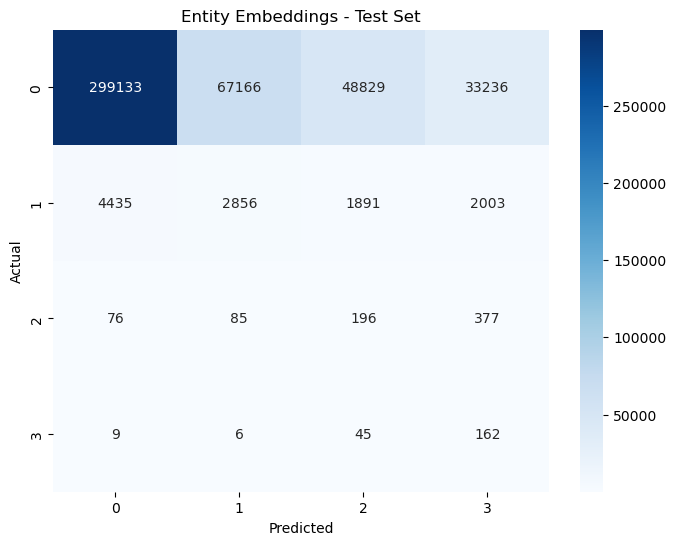

In [16]:
# Entity embeddings model metrics
y_pred_val_entity = np.argmax(entity_model.predict(val_inputs), axis=1)
y_pred_test_entity = np.argmax(entity_model.predict(test_inputs), axis=1)

entity_val_metrics = get_metrics(y_val_embed, y_pred_val_entity)
entity_test_metrics = get_metrics(y_test_embed, y_pred_test_entity)

print_metrics(entity_val_metrics, "Entity Embeddings (Validation)")
print_metrics(entity_test_metrics, "Entity Embeddings (Test)")

# Update results dict with true entity embeddings
results['Entity Embeddings'] = {
    'val': entity_val_metrics,
    'test': entity_test_metrics
}

plot_confusion_matrix(y_test_embed, y_pred_test_entity, "Entity Embeddings - Test Set")

---
## 7. Alt Approach: Entity Embeddings with Class Weights (Full Dataset)

Since undersampling reduces training data to only 2,640 samples (660 per class), we should 
also explore using the **full dataset with class weights** to handle imbalance.

This approach:
- Uses all ~1.3M training samples (preserving original class distribution)
- Applies class weights during training to penalize misclassification of minority classes
- May learn better representations with more data

In [17]:
# load full dataset w/ entity embeddings (no undersampling, no balanced sampling)
print("Loading full dataset with entity embeddings (n_per_class=None)...")
print("This will take longer as we're loading ~1.3M training samples...")

data_full = build_preprocessed_data(
    use_undersample=False,
    use_entity_embeddings=True,
    n_per_class=None  # use all data
)

# extract arrays
X_train_cont_full = data_full['X_train_cont'].astype('float32')
X_val_cont_full = data_full['X_val_cont'].astype('float32')
X_test_cont_full = data_full['X_test_cont'].astype('float32')

X_train_cat_full = data_full['X_train_cat']
X_val_cat_full = data_full['X_val_cat']
X_test_cat_full = data_full['X_test_cat']

y_train_full = data_full['Y_train']
y_val_full = data_full['Y_val']
y_test_full = data_full['Y_test']

print(f"\nFull dataset shapes:")
print(f"  Training: {len(y_train_full)} samples")
print(f"  Validation: {len(y_val_full)} samples")
print(f"  Test: {len(y_test_full)} samples")

# show class distribution
print(f"\nTraining class distribution (imbalanced):")
unique, counts = np.unique(y_train_full, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c:,} samples ({100*c/len(y_train_full):.2f}%)")

Loading full dataset with entity embeddings (n_per_class=None)...
This will take longer as we're loading ~1.3M training samples...
Scanning CSV for column names...


Loading 48 columns (out of 308 total)...
File loaded successfully with Polars. Shape: (2302521, 48)
Converting to Pandas...
Conversion complete. Pandas shape: (2302521, 48)
Using full dataset (n_per_class=None)
Integer-encoding categorical features for entity embeddings...
  NWCG_CAUSE_CLASSIFICATION: 3 unique values
  GACC_PL: 6 unique values

Full dataset shapes:
  Training: 1381512 samples
  Validation: 460504 samples
  Test: 460505 samples

Training class distribution (imbalanced):
  Class 0: 1,345,082 samples (97.36%)
  Class 1: 33,560 samples (2.43%)
  Class 2: 2,210 samples (0.16%)
  Class 3: 660 samples (0.05%)


In [18]:
# compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_full),
    y=y_train_full
)
class_weight_dict = dict(enumerate(class_weights))

print("Computed class weights (balanced):")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

Computed class weights (balanced):
  Class 0: 0.2568
  Class 1: 10.2914
  Class 2: 156.2796
  Class 3: 523.3000


In [19]:
# build entity embeddings model for class weights approach
print("Building entity embeddings model for class weights approach...")
entity_model_cw = build_entity_embeddings_model(
    n_continuous=len(data_full['cols_continuous']),
    cardinalities=data_full['cardinalities'],
    num_classes=num_classes
)

# prep inputs
n_cat_full = len(data_full['cols_categorical'])
train_inputs_full = [X_train_cont_full] + [X_train_cat_full[:, i:i+1] for i in range(n_cat_full)]
val_inputs_full = [X_val_cont_full] + [X_val_cat_full[:, i:i+1] for i in range(n_cat_full)]
test_inputs_full = [X_test_cont_full] + [X_test_cat_full[:, i:i+1] for i in range(n_cat_full)]

print(f"\nTraining with {len(y_train_full):,} samples and class weights...")

# train with class weights
early_stopping_cw = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cw = entity_model_cw.fit(
    train_inputs_full, y_train_full,
    validation_data=(val_inputs_full, y_val_full),
    class_weight=class_weight_dict,
    epochs=50,
    batch_size=512,  # Larger batch for bigger dataset
    callbacks=[early_stopping_cw],
    verbose=1
)

Building entity embeddings model for class weights approach...
  NWCG_CAUSE_CLASSIFICATION: cardinality=3, embed_dim=2
  GACC_PL: cardinality=6, embed_dim=3

Training with 1,381,512 samples and class weights...
Epoch 1/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5929 - loss: 1.1935 - val_accuracy: 0.6839 - val_loss: 0.9531
Epoch 2/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6231 - loss: 1.1020 - val_accuracy: 0.6292 - val_loss: 0.9324
Epoch 3/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6111 - loss: 1.0888 - val_accuracy: 0.6548 - val_loss: 0.8900
Epoch 4/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6194 - loss: 1.0723 - val_accuracy: 0.6494 - val_loss: 0.8580
Epoch 5/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6288 - loss: 1.0658 - val_accuracy: 0.6163 - val_loss: 0.8951
Epoch 6/50
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6357 - loss: 1.0637 - val_accuracy: 0.6434 - val_loss: 0.8863
Epo

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
14391/14391 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step

Entity Embeddings + Class Weights (Validation) Metrics:
  Accuracy:  0.6644
  Precision: 0.2617
  Recall:    0.5059
  F1 Score:  0.2266

Entity Embeddings + Class Weights (Test) Metrics:
  Accuracy:  0.6643
  Precision: 0.2620
  Recall:    0.5163
  F1 Score:  0.2271

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    448364
           1       0.05      0.39      0.08     11185
           2       0.01      0.33      0.01       734
           3       0.01      0.68      0.01       222

    accuracy                           0.66    460505
   macro avg       0.26      0.52      0.23    460505
weighted avg       0.96      0.66      0.78    460505



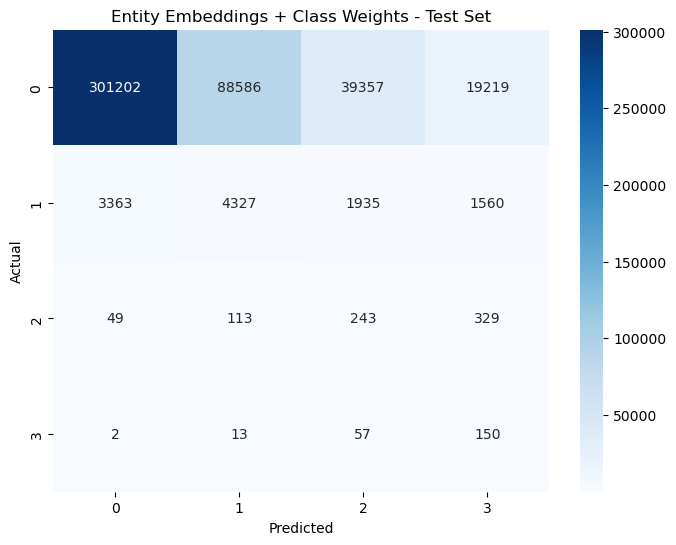

In [20]:
# Class weights model metrics
y_pred_val_cw = np.argmax(entity_model_cw.predict(val_inputs_full), axis=1)
y_pred_test_cw = np.argmax(entity_model_cw.predict(test_inputs_full), axis=1)

cw_val_metrics = get_metrics(y_val_full, y_pred_val_cw)
cw_test_metrics = get_metrics(y_test_full, y_pred_test_cw)

print_metrics(cw_val_metrics, "Entity Embeddings + Class Weights (Validation)")
print_metrics(cw_test_metrics, "Entity Embeddings + Class Weights (Test)")

# add to results
results['Entity Embed + Class Weights'] = {
    'val': cw_val_metrics,
    'test': cw_test_metrics
}

print("\nClassification Report (Test):")
print(classification_report(y_test_full, y_pred_test_cw))

plot_confusion_matrix(y_test_full, y_pred_test_cw, "Entity Embeddings + Class Weights - Test Set")

---
## 8. Model Comparison & Summary

Comparing all approaches:
- **Undersampling models**: Random Forest, FFNN, Entity Embeddings (2,640 training samples)
- **Class Weights model**: Entity Embeddings with full dataset (~1.3M training samples)

In [21]:
# create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Val Accuracy': metrics['val']['accuracy'],
        'Val Precision': metrics['val']['precision'],
        'Val Recall': metrics['val']['recall'],
        'Val F1': metrics['val']['f1'],
        'Test Accuracy': metrics['test']['accuracy'],
        'Test Precision': metrics['test']['precision'],
        'Test Recall': metrics['test']['recall'],
        'Test F1': metrics['test']['f1'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("=" * 48)
print("MODEL COMPARISON SUMMARY (Macro Average Metrics)")
print("=" * 48)
print("\nValidation Metrics:")
print(comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']].round(4))
print("\nTest Metrics:")
print(comparison_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']].round(4))

MODEL COMPARISON SUMMARY (Macro Average Metrics)

Validation Metrics:
                              Val Accuracy  Val Precision  Val Recall  Val F1
Model                                                                        
Random Forest                       0.6453         0.2620      0.5203  0.2233
FFNN                                0.6699         0.2593      0.4925  0.2241
Entity Embeddings                   0.6582         0.2587      0.4920  0.2211
Entity Embed + Class Weights        0.6644         0.2617      0.5059  0.2266

Test Metrics:
                              Test Accuracy  Test Precision  Test Recall  \
Model                                                                      
Random Forest                        0.6454          0.2618       0.5085   
FFNN                                 0.6693          0.2595       0.4979   
Entity Embeddings                    0.6566          0.2586       0.4798   
Entity Embed + Class Weights         0.6643          0.2620       0

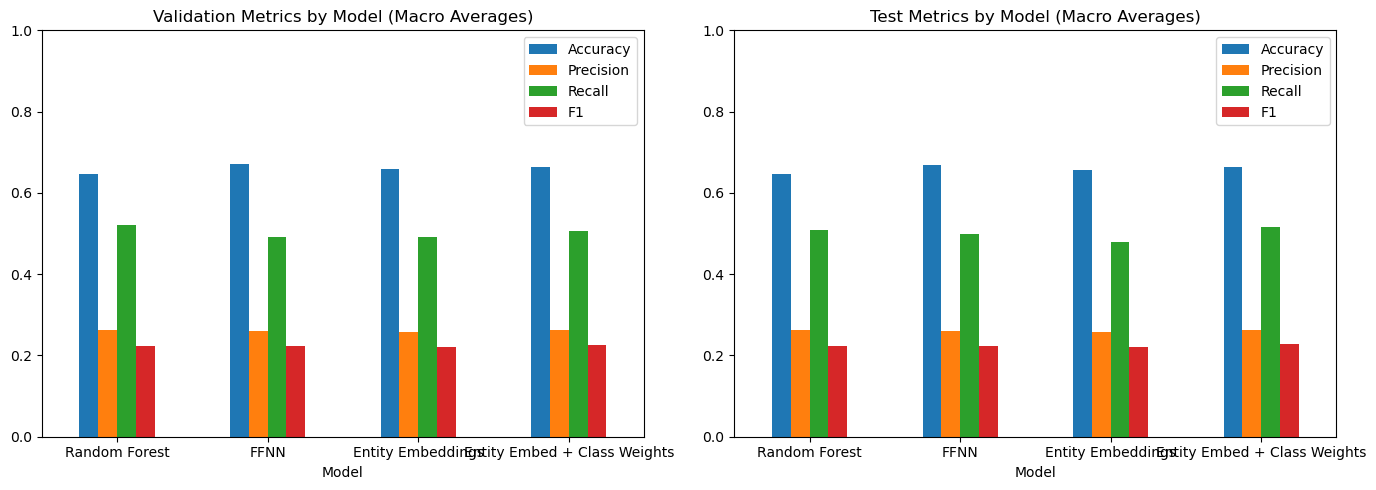

In [22]:
# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# validation metrics
val_metrics_df = comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']]
val_metrics_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
val_metrics_df.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Validation Metrics by Model (Macro Averages)')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='upper right')

# test metrics
test_metrics_df = comparison_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']]
test_metrics_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
test_metrics_df.plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Test Metrics by Model (Macro Averages)')
axes[1].set_ylim([0, 1])
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
# save results to CSV for reporting
comparison_df.to_csv('../data/processed/model_comparison_undersampling_CH.csv')
print("Results saved to data/processed/model_comparison_undersampling_CH.csv")

Results saved to data/processed/model_comparison_undersampling_CH.csv
